In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import os
import sys
#os.environ['HF_HOME'] = '/data/users/ugarg/hf/hf_cache/'
os.environ['TRANSFORMERS_CACHE'] = '/data/users/ugarg/hf/hf_cache/'
os.environ['CUDA_VISIBLE_DEVICES']='1'

#sys.path.append('../../..')
sys.path.append('../')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=False)
from torch.nn.functional import one_hot


from collections import Counter

from datasets import load_dataset, Dataset, DatasetDict
import pandas as pd
import torch
import numpy as np
import random
from transformers import AdamW, AutoTokenizer,  AutoModel
from torch.nn.functional import one_hot
from collections import Counter
from torch.optim import AdamW, Adam
from transformers import get_scheduler, get_cosine_with_hard_restarts_schedule_with_warmup

def seed_everything(seed: int):
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)
import joblib
import datetime
from tqdm.auto import tqdm





from utils.get_data_and_splits import LoadData
from utils.params import get_roberta_params, get_xlm_params
from utils.model import Model
from utils.utils import checkpoint_builder
from utils.faiss_utils import create_and_store_index, get_top_n_accuracy
from utils.predict import prep_model, predict_on_batch #

from CreatePytorchDataset import TrainDataset, ValDataset


INFO: Pandarallel will run on 48 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Seed set to 42


In [4]:
loaddata = LoadData()
train, val, test = loaddata.get_data("/data/users/abose1/Capstone/Dictionary_and_Word_Embeddings/data/static_wiki.pkl")

Start


100%|████████████████████████████████████| 4529/4529 [00:00<00:00, 46408.34it/s]


Len of Train before drop duplicates - 361167
Len of Val before drop duplicates - 4219
Len of Test before drop duplicates - 4227
Len of Train - 359767
Len of Val - 4219
Len of Test - 4227


In [3]:
train = joblib.load('../clean_data/train.joblib')
val = joblib.load('../clean_data/val.joblib')
test = joblib.load('../clean_data/test.joblib')

KeyboardInterrupt: 

In [ ]:
val

In [ ]:
print(f"Len of train = {len(train)}")
print(f"Len of dev = {len(val)}")
print(f"Len of test = {len(test)}")

In [ ]:
train.sample(6)

In [5]:
params = get_roberta_params()

In [6]:
params

{'model_checkpoint': 'roberta-large',
 'source_column': 'gloss',
 'max_len': 150,
 'batch_size': 64,
 'dropout': 0.3,
 'learning_rate': 0.0001,
 'num_epochs': 150,
 'early_stopping_limit': 5,
 'device': 'cuda:0',
 'loss_fn_name': 'cosine',
 'emb_type': 'fasttext',
 'use_adapters': True,
 'resume_from_checkpoint': True,
 'output_size': 300,
 'knn_measure': 'cosine'}

In [7]:
create_and_store_index(
    params['emb_type'], params['knn_measure'])

Loading Data for Indexing...
Creating FAISS Index...
FAISS Index Creation Done...


In [8]:

##################
#   tokenizer
##################

from transformers import AutoTokenizer

model_checkpoint = params['model_checkpoint']
print(f'\nLoading Tokenizer: {model_checkpoint} ...')
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)




Loading Tokenizer: roberta-large ...


In [ ]:
train[['word','gloss', 'fasttext']].info()

In [ ]:
save_checkpoint_path = f"checkpoints/{params['model_checkpoint']}_model_{params['loss_fn_name']}_loss_{params['emb_type']}_embs_{params['use_adapters']}_adapter.pt"




In [ ]:
save_checkpoint_path


In [ ]:
train_dataset = TrainDataset(
    train, 
    tokenizer, 
    params['source_column'],
    params['max_len'], 
    params['emb_type']
)
val_dataset = ValDataset(
    val, 
    tokenizer, 
    params['source_column'],
    params['max_len'], 
    params['emb_type']
)

In [ ]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn = data_collator,
    batch_size = params['batch_size'],
)
val_dataloader = DataLoader(
    val_dataset, 
    collate_fn = data_collator, 
    batch_size=params['batch_size']
)

In [ ]:

####################################
#   Load Model
####################################

print(f"\nUsing device {params['device']} for training...")

model = Model(params['model_checkpoint'], 
              params['output_size'], 
              params['dropout'], 
              params['device'], 
              params['loss_fn_name'], 
              params['use_adapters'])
model.to(params['device'])

1

In [17]:


####################################
#   Create Optimizer
####################################
print(f"\nCreating optimizer with Learning Rate: {params['learning_rate']}")


optimizer = AdamW(model.parameters(), lr = params['learning_rate'])

print(f"\nTraining for {params['num_epochs']} epochs with early stopping set to {params['early_stopping_limit']}\n\n")

num_train_epochs = params['num_epochs']
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=300,
    num_training_steps=num_training_steps,
)



Creating optimizer with Learning Rate: 0.0001

Training for 150 epochs with early stopping set to 5




In [18]:
progress_bar = tqdm(range(num_training_steps))
early_stopping_counter = 0
early_stopping_limit = params['early_stopping_limit']
best_valid_loss = float('inf')

for epoch in range(num_train_epochs):
    train_loss=0
    valid_loss =0
    

    
    print(f"[Epoch {epoch} / {num_train_epochs}]")
    # Training
    model.train()
    for batch_idx, batch in enumerate(train_dataloader):
        loss, out, actual = model(batch)
        #loss = outputs.loss
        loss.backward(loss)#, retain_graph = True)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        train_loss+= ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
        progress_bar.update(1)
        progress_bar.set_postfix(loss = train_loss)
        
        
    
    
    # Evaluation
    model.eval()
    for batch_idx, batch in enumerate(val_dataloader):
        with torch.no_grad():
            loss, out, actual = model(batch)


        labels = actual
        predictions = out
        
        valid_loss+= ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))
        

    print('\nEpoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

    #early stopping, checkpointing
    if valid_loss < best_valid_loss:
        early_stopping_counter = 0
        best_valid_loss = valid_loss
        #create checkpoint
        print("Loss improved saving checkpoint... ")
        checkpoint_builder(model, optimizer, epoch, save_checkpoint_path)

    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_limit:
            print(f'\nLoss did not reduce for last {early_stopping_counter} epochs. Stopped training..')
            break



  0%|          | 0/934350 [00:00<?, ?it/s]

[Epoch 0 / 150]

Epoch: 0 	Training Loss: 0.507712 	Validation Loss: 0.489098
Loss improved saving checkpoint... 


TypeError: checkpoint_builder() takes 4 positional arguments but 5 were given

## Prediction

* Here we load the model from checkpoint
* Create Search index
    * Created using Test + Val dataset
* Get nearest neighbours for dev predictions
* Get Average Rank and Top N accuracy
    * Average Rank - If the word is not found in nearest 500 words, we make the rank 500 for that word
    * Top N - If the word is in Top N nearest neighbours predicted

In [9]:
params = get_xlm_params()

In [10]:
tokenizer, model, data_collator, sim, faiss_index, faiss_idx_word_to_index_lookup, faiss_idx_index_to_word_lookup = prep_model(params)



Loading Tokenizer: xlm-roberta-large ...
Loading from : /data/users/ugarg/capstone/code/Dictionary_and_Word_Embeddings-main/gloss2word/v2/checkpoints/xlm-roberta-large_model_cosine_loss_fasttext_embs_True_adapter0.0001_lr.pt

Using device cuda:0 for training...


Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loading Checkpoint ...
Setting Models state to checkpoint...
Model state set.


ValueError: not enough values to unpack (expected 7, got 6)

In [21]:
len(faiss_idx_word_to_index_lookup)

409580

In [20]:
len(faiss_idx_index_to_word_lookup)

286681

In [28]:
model.eval()
1

1

In [74]:
#Use it if text in list
NEAREST_NEIGHBOUR_NUM = 409580

In [75]:
len(faiss_idx_word_lookup)

409580

In [76]:
val = joblib.load('../clean_data/val.joblib')

In [77]:
pred_batch = 50
ranks = []
for i in tqdm(range(0, len(val), pred_batch)):
    x = val.loc[i:i+pred_batch-1]
    
    preds = predict_on_batch(
        x['gloss'].values.tolist(), 
        tokenizer, model, data_collator, sim, faiss_index, 
        faiss_idx_word_lookup, NEAREST_NEIGHBOUR_NUM
    )
    for j in range(len(preds)):
        rank = get_rank(x['word'].values[j], preds[j], NEAREST_NEIGHBOUR_NUM)
        ranks.append(rank)
        
    
    # print(f"Gloss: {val.loc[i,'gloss']}")
    # print(f"Actual Word: {val.loc[i,'word']}")
    # print(f'Predicted: {list(dict.fromkeys(preds))[:5]}')
    # print('---\n')
print(f"Average Rank @{NEAREST_NEIGHBOUR_NUM} : {np.mean(ranks)}")

  0%|          | 0/110 [00:00<?, ?it/s]

Average Rank @409580 : 117252.99981798325


In [78]:
val['pred_rank'] = ranks

In [79]:
np.median(ranks)

128.0

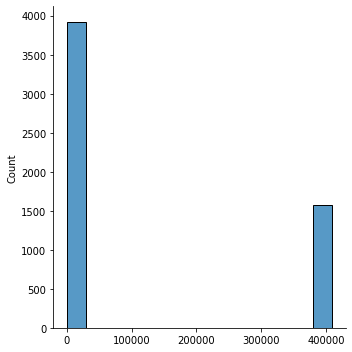

In [80]:
import seaborn as sns
sns.displot(ranks)

In [81]:
for n in [1,5,10,50,100]:
    print(f"Top {n} accuracy is {get_top_n_accuracy(ranks, n)}")

Top 1 accuracy is 0.137
Top 5 accuracy is 0.221
Top 10 accuracy is 0.27
Top 50 accuracy is 0.415
Top 100 accuracy is 0.479


In [23]:
text = ["able to turn freely about an axis."]

In [25]:
preds = predict_on_batch(
        text, 
        tokenizer, model, data_collator, sim, faiss_index, 
        faiss_idx_index_to_word_lookup, 5
    )
#words = list(dict.fromkeys(preds))[:25]

# for word in words:
#     gloss = df[df.word==word]['gloss'].values
    
#     print(f'{word}: \n{gloss}\n')

In [26]:
preds

array([[339900, 328171, 383486,  91375, 209822]])

* Any gloss to word
* You give any word - "bokizona": the top of a lamp made of wood

In [ ]:
#Use it if text in list
# faiss_idx_word_lookup = joblib.load('faiss_idx_word_lookup.joblib')
# sim = Similarity()
# ranks = []
# for i in tqdm(range(len(val))):
    
#     preds = predict_on_sentence(val.loc[i,'gloss'], sim, faiss_idx_word_lookup)
#     rank = get_rank(val.loc[i, 'word'], preds)
#     ranks.append(rank)
#     # print(f"Gloss: {val.loc[i,'gloss']}")
#     # print(f"Actual Word: {val.loc[i,'word']}")
#     # print(f'Predicted: {list(dict.fromkeys(preds))[:5]}')
#     # print('---\n')

In [73]:
1

1

In [82]:
val.sample(10)

,word,gloss,fasttext,pred_rank
3071,mushy,"Overly sappy , corny , or cheesy","[-0.0917, -0.4726, -0.0255, 0.0673, 0.1981, 0....",639
1623,emotional,Easily affected by emotion .,"[0.2489, 0.0254, 0.2088, -0.1229, 0.375, -0.32...",14
4736,synchronically,In a synchronic way,"[0.0917, 0.3119, -0.2979, -0.0922, -0.1644, -0...",1
3877,rebuild,A process or result of rebuilding .,"[0.1659, 0.0074, 0.0992, 0.2391, -0.3666, -0.0...",1
2613,jubilation,rejoicing,"[0.4779, -0.3126, -0.1331, 0.0347, -0.0798, -0...",5
3358,palace,To decorate or ornate .,"[-0.0523, -0.415, 0.0576, 0.0265, -0.6142, 0.0...",409580
5464,write,often used reflexively .,"[-0.1804, 0.0429, -0.093, -0.0897, 0.2307, 0.1...",409580
3305,oropharynx,"The oral part of the pharynx , reaching from t...","[-0.1871, 0.2104, -0.0528, 0.208, -0.1884, 0.2...",60
850,cardinal,Of or relating to the cardinal directions ( no...,"[-0.1016, 0.1126, -0.4016, -0.4115, -0.2766, 0...",409580
2384,hoofprint,The mark of a hoof .,"[0.2603, -0.3164, -0.4397, 0.0254, -0.1064, -0...",20


In [ ]:
* Full stop
* 

In [87]:
'cardinal' in set([i[1] for i in faiss_idx_word_lookup.items()])

True

In [1]:
import numpy as np

In [24]:
a = np.array([1,2,3]) 
a = a / sum(a**2)**0.5
b = np.array([.1,1,1]) 
b = b / sum(b**2)**0.5


In [25]:
a

array([0.26726124, 0.53452248, 0.80178373])

In [26]:
b

array([0.07053456, 0.70534562, 0.70534562])

In [27]:
np.dot(a,b)

0.9614088808864494